In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm as lgb
from lightgbm import early_stopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
import re

## Loading Data


In [4]:
train_df = pd.read_csv('data/train.csv', index_col="id")
test_df = pd.read_csv('data/test.csv')

##  Initial Data Overview

In [5]:
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Train Data Shape: (188533, 12)
Test Data Shape: (125690, 12)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Handling Missing Values<p>


In [9]:
missing_values = train_df.isnull().sum()/train_df.shape[0] * 100
print("\nTrain Data Missing Values:\n\n", missing_values)

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0]



Train Data Missing Values:

 brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64


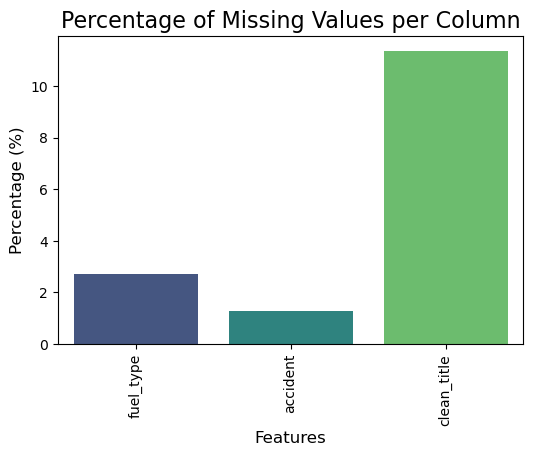

In [10]:
# Plotting the missing values
plt.figure(figsize=(6, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values per Column', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()


In [11]:
# Checking the number of missing values in the train data

fuel_missing = train_df['fuel_type'].isna().sum()
accident_missing = train_df['accident'].isna().sum()
cleanTitle_missing = train_df['clean_title'].isna().sum()

print("Missing Values")
print("Fuel Type:", fuel_missing)
print("Accident:", accident_missing)
print("Clean Title:", cleanTitle_missing)

Missing Values
Fuel Type: 5083
Accident: 2452
Clean Title: 21419


In [12]:
# TEST DATA MISSING VALUES

missing_values = test_df.isnull().sum()/test_df.shape[0] * 100
print("\nTest Data Missing Values:\n\n", missing_values)

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0]


Test Data Missing Values:

 id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.691543
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.298433
clean_title     11.328666
dtype: float64


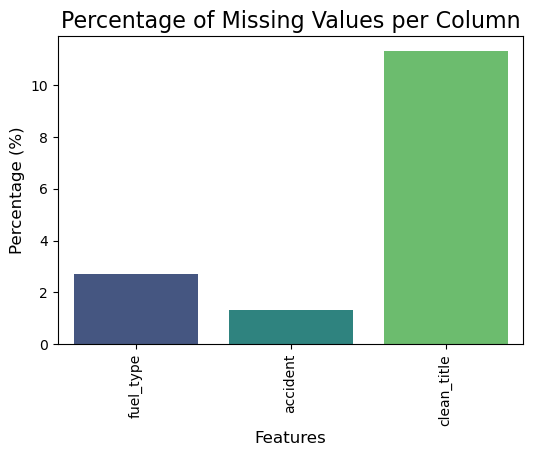

In [13]:
# Plotting the missing values
plt.figure(figsize=( 6, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values per Column', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()

In [14]:
# Checking the number of missing values in the test data

fuel_missing = test_df['fuel_type'].isna().sum()
accident_missing = test_df['accident'].isna().sum()
cleanTitle_missing = test_df['clean_title'].isna().sum()

print("Missing Values")
print("Fuel Type:", fuel_missing)
print("Accident:", accident_missing)
print("Clean Title:", cleanTitle_missing)

Missing Values
Fuel Type: 3383
Accident: 1632
Clean Title: 14239


###  Filling the missing values in the train data and test data of the 'fuel_type' column with Electricity 


In [15]:

train_df['fuel_type'].fillna('Electricity', inplace=True)
test_df['fuel_type'].fillna('Electricity', inplace=True)

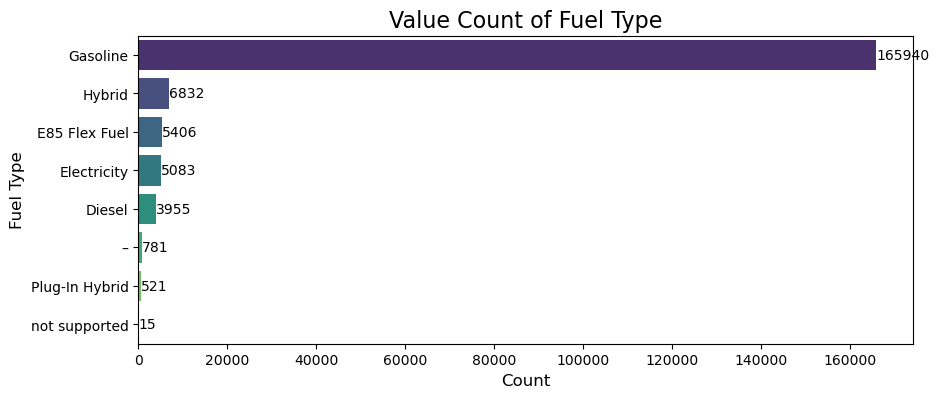

In [16]:
plt.figure(figsize=(10, 4))

# Create horizontal bar chart
sns.barplot(x=train_df['fuel_type'].value_counts().values, 
            y=train_df['fuel_type'].value_counts().index, 
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(train_df['fuel_type'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=10)

# Titles and labels
plt.title('Value Count of Fuel Type', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Fuel Type', fontsize=12)

# Show the plot
plt.show()

### Filling the missing values in the 'clean_title' column with 'No' in both train and test data 


In [17]:
train_df['clean_title'].fillna('No', inplace=True)
test_df['clean_title'].fillna('No', inplace=True)

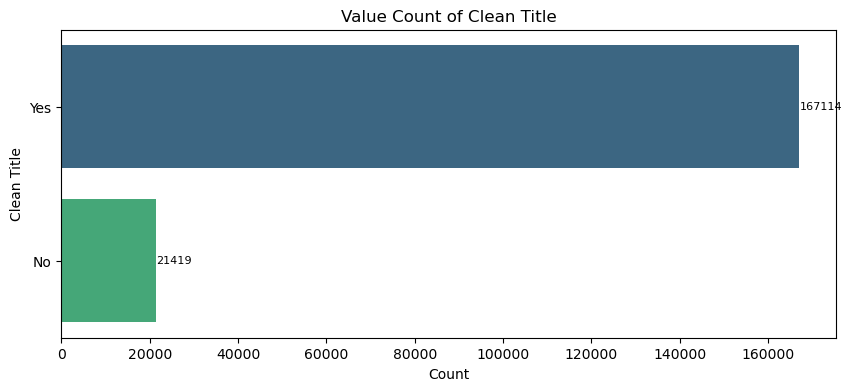

In [18]:
plt.figure(figsize=(10, 4))

# Create horizontal bar chart
sns.barplot(x=train_df['clean_title'].value_counts().values, 
            y=train_df['clean_title'].value_counts().index, 
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(train_df['clean_title'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=8)

# Titles and labels
plt.title('Value Count of Clean Title', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Clean Title', fontsize=10)

# Show the plot
plt.show()

### Filling missing values in the 'accident' column with 'None reported'

In [19]:
train_df['accident'].fillna('None reported', inplace=True)
test_df['accident'].fillna('None reported', inplace=True)

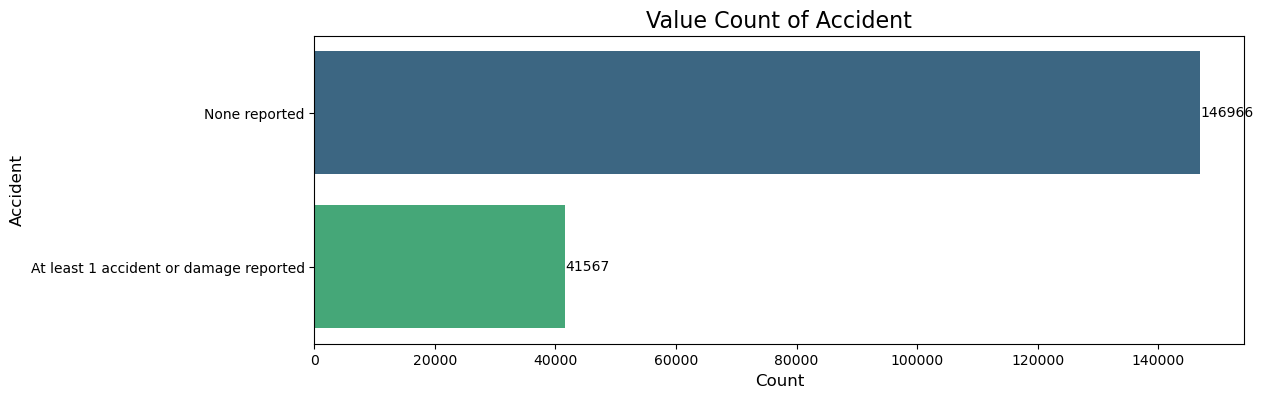

In [20]:
plt.figure(figsize=(12, 4))

# Create horizontal bar chart
sns.barplot(x=train_df['accident'].value_counts().values, 
            y=train_df['accident'].value_counts().index, 
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(train_df['accident'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=10)

# Titles and labels
plt.title('Value Count of Accident', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Accident', fontsize=12)

# Show the plot
plt.show()

## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Data Preprocessing<p>


In [21]:
print(train_df['engine'].head())

id
0         172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
1         252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel
2    320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
3         420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel
4         208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
Name: engine, dtype: object


### Extracting Engine features from the engine column in the Train and Test Data and creating new features like horsepower, displacement, engine Type, cylinder count, and fuel type

In [22]:


def extract_engine_features(df):
    
    # Extract Horsepower
    df['Horsepower'] = df['engine'].apply(lambda x: float(re.search(r'(\d+(\.\d+)?)HP', x).group(1)) if re.search(r'(\d+(\.\d+)?)HP', x) else None)

    # Extract Displacement
    df['Displacement'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x).group(1) or re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x).group(2)) if re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', x) else None)

    # Extract Engine Type
    df['Engine Type'] = df['engine'].apply(lambda x: re.search(r'(V\d+|I\d+|Flat \d+|Straight \d+)', x).group(1) if re.search(r'(V\d+|I\d+|Flat \d+|Straight \d+)', x) else None)

    # Extract Cylinder Count
    df['Cylinder Count'] = df['engine'].apply(lambda x: int(re.search(r'(\d+) Cylinder', x).group(1)) if re.search(r'(\d+) Cylinder', x) else None)

    # Extract Fuel Type
    fuel_types = ['Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Flex Fuel']
    df['Fuel Type'] = df['engine'].apply(lambda x: next((fuel for fuel in fuel_types if fuel in x), None))
    
    return df

train_df = extract_engine_features(train_df)
test_df = extract_engine_features(test_df)

In [23]:
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Engine Type,Cylinder Count,Fuel Type
id,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,None,4.0,Gasoline
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,None,8.0,Gasoline
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,None,8.0,Flex Fuel
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,None,8.0,Gasoline
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,None,4.0,Gasoline


###  Extracting the model age from the model column

In [24]:
import datetime
current_year = datetime.datetime.now().year
train_df['model_age'] = current_year - train_df['model_year']
test_df['model_age'] = current_year - test_df['model_year']
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Engine Type,Cylinder Count,Fuel Type,model_age
id,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,None,4.0,Gasoline,17
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,None,8.0,Gasoline,22
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,None,8.0,Flex Fuel,22
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,None,8.0,Gasoline,7
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,None,4.0,Gasoline,3


### Drop the columns that are no longer needed

In [25]:
columns_to_drop = ['engine', 'model','model_year', 'Engine Type', 'Fuel Type']
train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True)
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True)

In [26]:
# Iterative Imputer: Limit max iterations and increase tolerance
imputer = IterativeImputer(max_iter=10, tol=1e-3, random_state=0)

# Apply only to relevant columns that require more sophisticated imputation
train_df[['Horsepower', 'Displacement']] = imputer.fit_transform(train_df[['Horsepower', 'Displacement']])
test_df[['Horsepower', 'Displacement']] = imputer.transform(test_df[['Horsepower', 'Displacement']])

# Simple Imputer for less complex columns
simple_imputer = SimpleImputer(strategy='mean')
train_df['Cylinder Count'] = simple_imputer.fit_transform(train_df[['Cylinder Count']])
test_df['Cylinder Count'] = simple_imputer.transform(test_df[['Cylinder Count']])

In [27]:
def map_transmission(transmission):
    transmission = transmission.strip().lower()
    
    if any(kw in transmission for kw in ['a/t', 'automatic']):
        return 'Automatic'
    elif any(kw in transmission for kw in ['m/t', 'manual']):
        return 'Manual'
    elif any(kw in transmission for kw in ['cvt', 'variator']):
        return 'Variator'
    elif any(kw in transmission for kw in ['tiptronic']):
        return 'Tiptronic'
    else:
        return 'Other'

train_df['transmission'] = train_df['transmission'].apply(map_transmission)
test_df['transmission'] = test_df['transmission'].apply(map_transmission)
print("Train Data")
print('='*20)
print(train_df['transmission'].value_counts())
print("\nTest Data")
print('='*20)
print(test_df['transmission'].value_counts())

Train Data
transmission
Automatic    150302
Other         19868
Manual        16358
Variator       2005
Name: count, dtype: int64

Test Data
transmission
Automatic    100296
Other         13260
Manual        10785
Variator       1349
Name: count, dtype: int64


In [28]:
def mapping_columns(df):
    # Replace values in the 'accident' column
    df["accident"] = df["accident"].replace({
        'At least 1 accident or damage reported': 1,
        'None reported': 0
    })
    
    # Replace values in the 'clean_title' column
    df["clean_title"] = df["clean_title"].replace({
        "Yes": 1,
        "No": 0
    })
    
    # Replace values in the 'transmission' column
    df["transmission"] = df["transmission"].replace({'Automatic':1,
                                                'Manual':2,
                                                'Variator':3,
                                                'Other':4})

    return df

train_df = mapping_columns(train_df)
test_df = mapping_columns(test_df)

In [29]:
train_df.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Cylinder Count,model_age
id,,,,,,,,,,,,,
0,MINI,213000,Gasoline,1,Yellow,Gray,0,1,4200,172.0,1.6,4.0,17
1,Lincoln,143250,Gasoline,1,Silver,Beige,1,1,4999,252.0,3.9,8.0,22
2,Chevrolet,136731,E85 Flex Fuel,1,Blue,Gray,0,1,13900,320.0,5.3,8.0,22
3,Genesis,19500,Gasoline,4,Black,Black,0,1,45000,420.0,5.0,8.0,7
4,Mercedes-Benz,7388,Gasoline,1,Black,Beige,0,1,97500,208.0,2.0,4.0,3


In [30]:
test_df.head()

,id,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Displacement,Cylinder Count,model_age
0,188533,Land,98000,Gasoline,1,White,Beige,0,1,240.000000,2.0,4.000000,9
1,188534,Land,9142,Hybrid,1,Silver,Black,0,1,395.000000,3.0,6.000000,4
2,188535,Ford,28121,Gasoline,1,White,Ebony,0,0,324.100570,3.5,6.374268,2
3,188536,Audi,61258,Gasoline,1,Silician Yellow,Black,0,0,244.553252,2.0,6.374268,8
4,188537,Audi,59000,Gasoline,1,Gray,Black,0,1,252.000000,2.0,4.000000,6


In [31]:
# Encoding categorical variables
categorical_columns = ['brand', 'fuel_type', 'ext_col', 'int_col']
lb = LabelEncoder()

for col in categorical_columns:
    if col in train_df.columns:
        train_df[col] = lb.fit_transform(train_df[col])
        test_df[col] = lb.transform(test_df[col])

In [32]:
train_df.reset_index(drop=True, inplace=True)

In [33]:
train_df.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Displacement,Cylinder Count,model_age
0,31,213000,3,1,312,71,0,1,4200,172.0,1.6,4.0,17
1,28,143250,3,1,263,10,1,1,4999,252.0,3.9,8.0,22
2,9,136731,1,1,38,71,0,1,13900,320.0,5.3,8.0,22
3,16,19500,3,4,29,14,0,1,45000,420.0,5.0,8.0,7
4,36,7388,3,1,29,10,0,1,97500,208.0,2.0,4.0,3


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Data Visualization<p>


### Printing the Correlation matrix


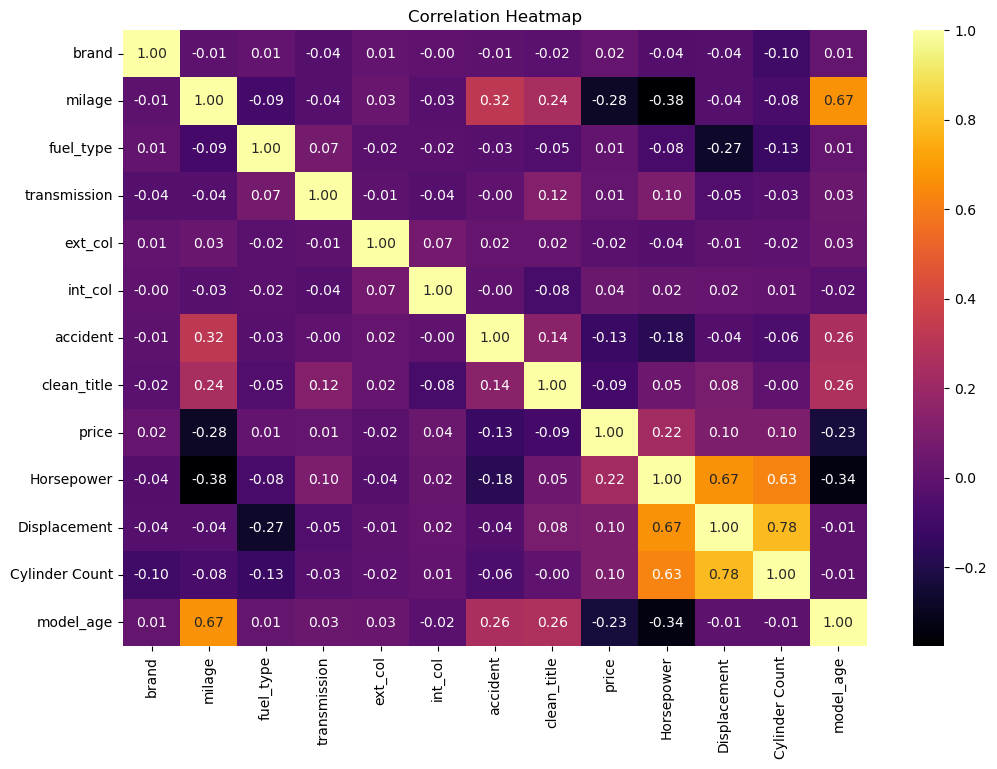

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='inferno', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

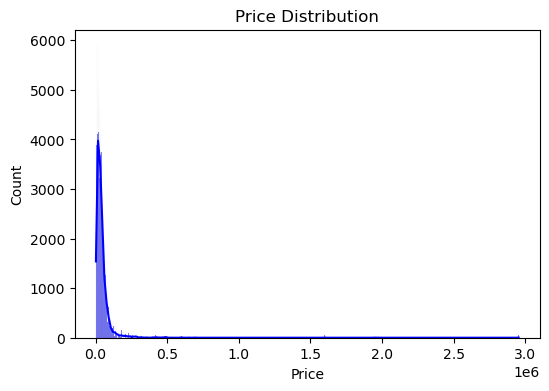

In [35]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['price'], kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

In [36]:
print(train_df['price'].head())
train_df['price'] = np.log1p(train_df['price'])
print(train_df['price'].head())


0     4200
1     4999
2    13900
3    45000
4    97500
Name: price, dtype: int64
0     8.343078
1     8.517193
2     9.539716
3    10.714440
4    11.487618
Name: price, dtype: float64


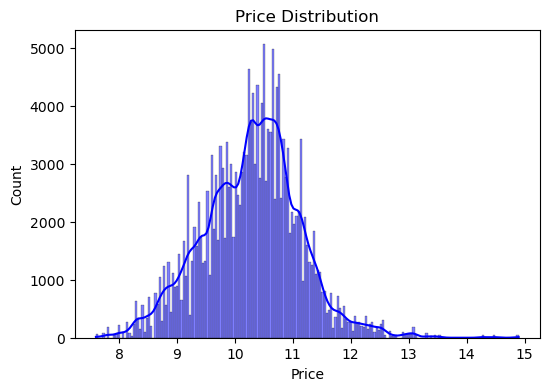

In [37]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['price'], kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brand           188533 non-null  int32  
 1   milage          188533 non-null  int64  
 2   fuel_type       188533 non-null  int32  
 3   transmission    188533 non-null  int64  
 4   ext_col         188533 non-null  int32  
 5   int_col         188533 non-null  int32  
 6   accident        188533 non-null  int64  
 7   clean_title     188533 non-null  int64  
 8   price           188533 non-null  float64
 9   Horsepower      188533 non-null  float64
 10  Displacement    188533 non-null  float64
 11  Cylinder Count  188533 non-null  float64
 12  model_age       188533 non-null  int64  
dtypes: float64(4), int32(4), int64(5)
memory usage: 15.8 MB


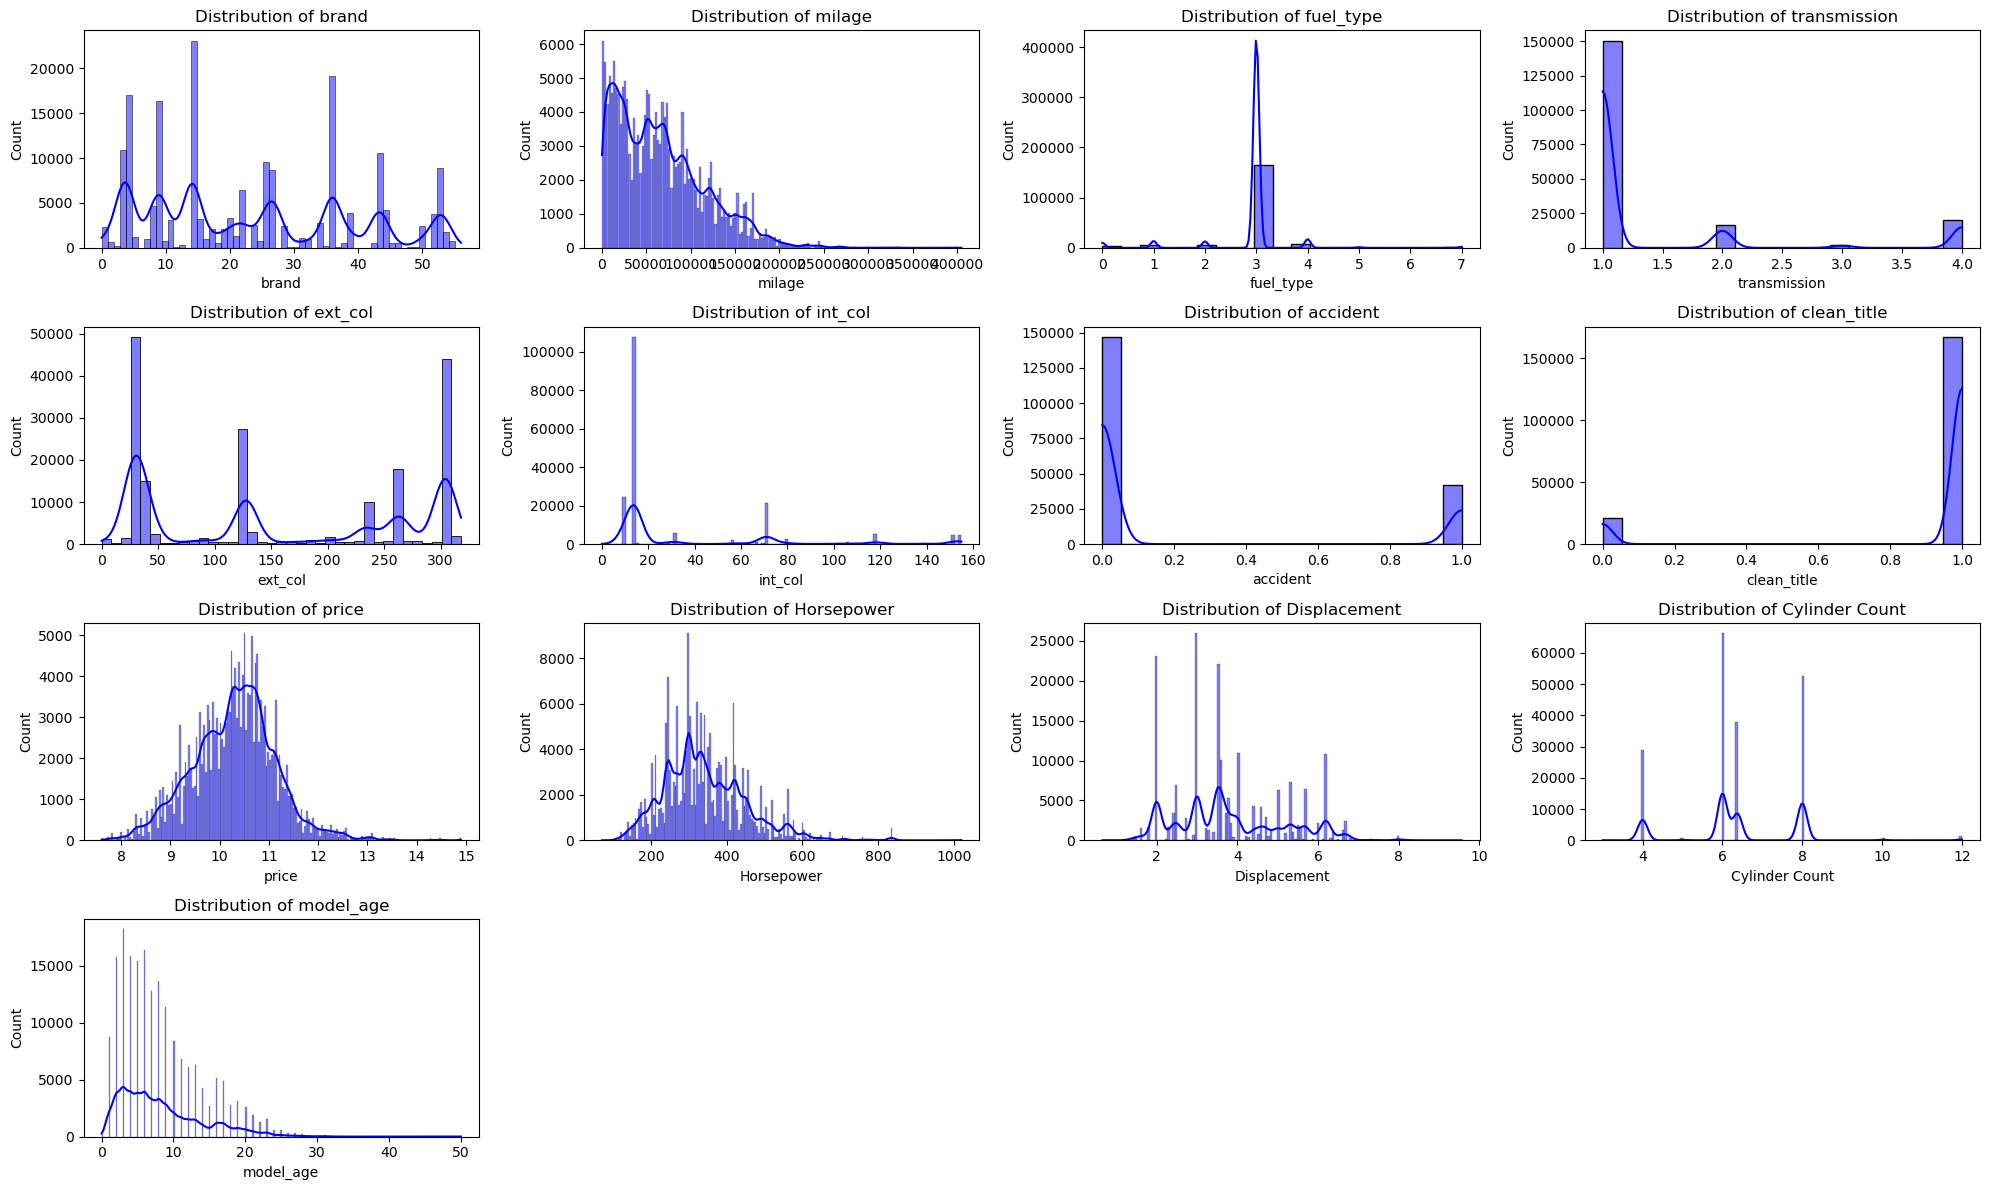

In [39]:
n_rows = 4
n_cols = 4

num_columns = train_df.select_dtypes(include=['float64', 'int64', "int32"]).columns

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))

axes = axes.flatten()

for i, col in enumerate(num_columns):
    sns.histplot(train_df[col], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)

for j in range(len(num_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Data Preparation<p>


### Splitting the data into Target and Features

In [40]:
X = train_df.drop(['price'],axis=1)
y = train_df['price']
X.shape, y.shape

((188533, 12), (188533,))

### Scaling the data using Standard Scalar

In [41]:
scaler = StandardScaler()

continuous_features = ['milage', 'Horsepower', 'Displacement', 'Cylinder Count', 'model_age']
train_df[continuous_features] = scaler.fit_transform(train_df[continuous_features])

test_df[continuous_features] = scaler.transform(test_df[continuous_features])

### Splitting Data into Train Set and Validation Set

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Linear Regression<p>


In [43]:
Linear_Regression_model = LinearRegression()
Linear_Regression_model.fit(X_train, y_train)

y_pred_Linear_Regression = Linear_Regression_model.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred_Linear_Regression) - np.expm1(y_val))**2))

print(f'Linear Regression RMSE: {rmse:.2f}')

Linear Regression RMSE: 70546.76


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Decision Tree<p>

In [44]:
Parameter_Dict_Decision_Tree = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

decision_tree = DecisionTreeRegressor(random_state=42)

# Random search over the parameter grid
random_search_dt = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=Parameter_Dict_Decision_Tree,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42
)

# Fit the model
random_search_dt.fit(X_train, y_train)
BEST_PARAMS_Decision_Tree = random_search_dt.best_params_
print("Best Parameters for Decision Tree:", BEST_PARAMS_Decision_Tree)

y_pred_Decision_Tree = random_search_dt.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred_Decision_Tree) - np.expm1(y_val))**2))

print(f'Optimized Decision Tree RMSE: {rmse:.2f}')

Best Parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'friedman_mse'}
Optimized Decision Tree RMSE: 70452.16


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">ADA BOOST<p>

In [46]:
parameter_Dict_ADA_BOOST = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.1, 0.5], 
    'loss': ['linear', 'square'],  
    'estimator__max_depth': [3, 5],  
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

base_tree = DecisionTreeRegressor(random_state=42)
ada_reg = AdaBoostRegressor(estimator=base_tree, random_state=42)

random_search_ada = RandomizedSearchCV(
    estimator=ada_reg,
    param_distributions=parameter_Dict_ADA_BOOST,
    n_iter=10,  
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1 
)

random_search_ada.fit(X_train, y_train)

best_params_ada = random_search_ada.best_params_
print("Best Parameters for AdaBoost Regressor:", best_params_ada)

y_pred = random_search_ada.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(y_val))**2))

print(f'Optimized AdaBoost RMSE: {rmse:.2f}')

Best Parameters for AdaBoost Regressor: {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.1, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 5}
Optimized AdaBoost RMSE: 69689.02


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Random Forest Regressor<p>

In [47]:
Parameter_Dict_Random_Forest = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

Random_Forest_model = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=Random_Forest_model,
    param_distributions=Parameter_Dict_Random_Forest,
    n_iter=10, 
    scoring='neg_mean_squared_error',
    cv=3,  
    random_state=42,
    n_jobs=-1 
)

random_search_rf.fit(X_train, y_train)
best_params_rf = random_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

y_pred = random_search_rf.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(y_val))**2))

print(f'Optimized Random Forest RMSE: {rmse:.2f}')

Best Parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Optimized Random Forest RMSE: 68741.34


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Elastic Net<p>

In [48]:
Parameter_Dict_Elastic_net = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
    'l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0],
    'max_iter': [1000, 2000, 3000, 5000],
    'tol': [1e-4, 1e-3, 1e-2]
}

elastic_net_model = ElasticNet(random_state=42)

random_search_en = RandomizedSearchCV(
    estimator=elastic_net_model,
    param_distributions=Parameter_Dict_Elastic_net,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42
)

random_search_en.fit(X_train, y_train)
best_params_en = random_search_en.best_params_
print("Best Parameters for Elastic Net:", best_params_en)

y_pred = random_search_en.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(y_val))**2))

print(f'Optimized ElasticNet RMSE: {rmse:.2f}')

Best Parameters for Elastic Net: {'tol': 0.0001, 'max_iter': 5000, 'l1_ratio': 0.0, 'alpha': 0.001}
Optimized ElasticNet RMSE: 70547.15


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Catboost<p>

In [50]:
Parameter_Dict_Catboost = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5],
    'bagging_temperature': [0.5, 0.8],
    'border_count': [32, 64]
}

catboost_random = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=Parameter_Dict_Catboost,
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_squared_error',
    random_state=69,
    n_jobs=-1 
)

catboost_random.fit(X_train, y_train)
best_params = catboost_random.best_params_
print("Best Parameters:", best_params)

y_pred = catboost_random.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(y_val))**2))

print(f'Optimized CatBoost RMSE: {rmse:.2f}')

Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 8, 'border_count': 64, 'bagging_temperature': 0.5}
Optimized CatBoost RMSE: 68770.22


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">LightGBM<p>

In [49]:
LGB_parameters_dict = {
    'objective': 'regression',
    'subsample': 0.95, 
    'reg_lambda': 0.005623413251903491, 
    'reg_alpha': 1.0, 
    'num_leaves': 570, 
    'n_estimators': 550, 
    'min_data_in_leaf': 135, 
    'min_child_weight': 0.02, 
    'max_depth': 13, 
    'learning_rate': 0.015, 
    'feature_fraction': 0.85, 
    'colsample_bytree': 0.9, 
    'cat_smooth': 50, 
    'bagging_freq': 9, 
    'bagging_fraction': 0.85
}

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(**LGB_parameters_dict, random_state=42, verbose=-1)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

lgb_pred = lgb_model.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(lgb_pred) - np.expm1(y_val))**2))

print(f'Optimized LightGBM RMSE: {rmse:.2f}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[550]	valid_0's l2: 0.242064
Optimized LightGBM RMSE: 68695.82


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Catboost<p>

In [59]:
parameter_Dict_XG_BOOST = {
    "objective": ["reg:squarederror"],
    "learning_rate": [0.01, 0.1], 
    "n_estimators": [500, 1000],  
    "max_depth": [3, 5], 
    "min_child_weight": [1, 3],  
    "subsample": [0.7, 1.0], 
    "colsample_bytree": [0.7, 1.0],  
    "gamma": [0, 0.1],  
    "reg_alpha": [0, 0.1],  
    "reg_lambda": [0, 0.1],
}
xgb_model = xgb.XGBRegressor(verbose=0)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=parameter_Dict_XG_BOOST,
    n_iter=10, 
    scoring="neg_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
)

random_search_xgb.fit(
    X_train, y_train, eval_set=[(X_val, y_val)], verbose=False
)

best_params = random_search_xgb.best_params_
print("Best Parameters:", best_params)


xgb_pred = random_search_xgb.predict(X_val)

rmse = np.sqrt(np.mean((np.expm1(xgb_pred) - np.expm1(y_val)) ** 2))

print(f"Optimized XgBoost RMSE: {rmse:.2f}")

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Optimized XgBoost RMSE: 68763.30


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Artificial Neural Network<p>

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam


# Input layer and hidden layers
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')  
])


# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005))

# Define callbacks
es = EarlyStopping(monitor='val_loss', patience=19, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=19, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val),callbacks=[es, lr])

Epoch 1/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 16.3595 - val_loss: 0.7066 - learning_rate: 0.0050
Epoch 2/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3436 - val_loss: 0.6099 - learning_rate: 0.0050
Epoch 3/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3202 - val_loss: 0.5383 - learning_rate: 0.0050
Epoch 4/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3141 - val_loss: 0.3175 - learning_rate: 0.0050
Epoch 5/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3217 - val_loss: 0.3765 - learning_rate: 0.0050
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3085 - val_loss: 0.3069 - learning_rate: 0.0050
Epoch 7/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3094 - val_loss: 0.3828 - learning_rate: 0.0050
Epoch 8/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3100 - val_loss: 0.2979 - learning_rate: 0.0050
Epoch 9/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3085 - val_loss: 0.3263 - lear

In [52]:
ANN_pred = model.predict(X_val).flatten()
rmse = np.sqrt(np.mean((np.expm1(ANN_pred) - np.expm1(y_val))**2))
print(f'ANN RMSE: {rmse:.2f}')

1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step
ANN RMSE: 71061.95


## <p style="text-align:center; background-color:orange ; color : black; padding:20px; border-radius:30px">Essembling <p>

### Essemble Method - LightGBM, CatBoost and XGBoost using Blending

In [60]:
X_test = test_df.drop(['id'],axis=1)
lgb_pred = lgb_model.predict(X_test)
cat_pred = catboost_random.predict(X_test)
xgb_pred = random_search_xgb.predict(X_test)


blended_pred_test = (lgb_pred / 68695.82 + cat_pred / 68780.00 + xgb_pred / 68781.07) / (1/68695.82 + 1/68780.00 + 1/68781.07)


In [61]:
blended_pred_test = np.expm1(blended_pred_test)
blended_pred_test

array([37438.76430489, 41764.88820999, 36090.57419274, ...,
       41514.24693975, 41514.24693975, 39315.17365508])

In [62]:
submission = pd.DataFrame({
    'id': test_df['id'],  
    'price': blended_pred_test
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
